#  <center> Problem Set 5 <center>
<center> Spring 2022 <center>
<center> 3.C01/3.C51, 10.C01/10.C51, 20.C01/20.C51 <center>
<center> Due: 10 PM ET on Thursday, April 21, 2022 <center>

In [104]:
import os 
import glob 
import PIL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
import imageio
from skimage import io, color

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch import nn 
from torchvision.models import vgg16
import torch.optim as optim

## Part 1: Classifying  Steel  Surface  Defects

In [105]:
!wget https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps5/data/neu_surface_defect_jpg.tar.gz
!tar -xf neu_surface_defect_jpg.tar.gz

--2022-04-21 19:31:19--  https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps5/data/neu_surface_defect_jpg.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20738857 (20M) [application/octet-stream]
Saving to: ‘neu_surface_defect_jpg.tar.gz.1’

neu_surface_defect_ 100%[===================>]  19.78M  --.-KB/s    in 0.08s   

2022-04-21 19:31:20 (234 MB/s) - ‘neu_surface_defect_jpg.tar.gz.1’ saved [20738857/20738857]



### 1.1 (15 points)  Build Image Datasets and DataLoaders

Get all the image filepaths.

In [106]:
files = glob.glob(os.path.join('neu_surfae_defect_images', "*.jpg"))

Visualize a random image.

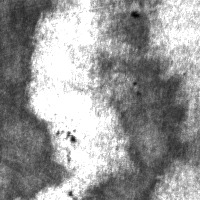

In [107]:
idx = 30
img = Image.open(files[idx])
img



Your ImageDataset class.

In [108]:
# dictionary labels 
label_dict = {
'Cr': 0, 
'In': 1, 
'Pa': 2,
'PS': 3, 
'RS': 4,
'Sc': 5
}

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        
        '''
        Image dataset object that loads and transforms images. 
        
        '''
        
        self.paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        #########your implementation here######### 
        
        # read images given file path 
        
        img = Image.open(self.paths[idx])
        img = img.convert('RGB')

        transform_list = []
        transform_list.append(transforms.Resize((224,224)))
        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)))

        p = transforms.Compose(transform_list)
        img = p(img)
        img.type(torch.FloatTensor)
        pre_key = self.paths[idx].split('/')
        key = pre_key[1].split('_')[0] # fill in
        single_label = label_dict[key]
        label = torch.cuda.LongTensor([single_label])
        
        #########your implementation here#########

        # transform images 
        if self.transform:
            img = self.transform(img)

        sample = img, label
        return sample

Transform your dataset, split the data, and define your Datasets and DataLoaders.

In [109]:


tr_andv_files, test_files = train_test_split(files, test_size = 0.2)
train_files, val_files = train_test_split(tr_andv_files,test_size=0.1/0.8)

train_data = ImageDataset(train_files)
val_data = ImageDataset(val_files)
test_data = ImageDataset(test_files)

#print(ImageDataset(train_files).__getitem__(10))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=True)



### 1.2 (10 points) Understand the Model Architecture

Define and load a pretrained VGG16 model.

In [110]:
class VGG_fc1(nn.Module):
    def __init__(self, pretrain=True):
        super(VGG_fc1, self).__init__()
        self.features = vgg16(pretrained=pretrain).features # convolutional layers
        self.avgpool = vgg16(pretrained=pretrain).avgpool
        self.fc1 = vgg16(pretrained=pretrain).classifier[0] # first layer of classifier
        
    def forward(self, x):
        """Extract first fully connected feature vector"""
        # Apply convolutions
        x = self.features(x)
        # Apply pooling
        x = self.avgpool(x)
        # Flatten and convert to vectors
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
    
model = VGG_fc1(pretrain=True).eval() # turn model into evaluation mode

The model architecture.

In [111]:
print(model)

VGG_fc1(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

Choose an image from your training set and visualize 4 channels in each of layers 1, 5, and 10.

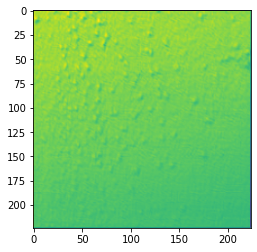

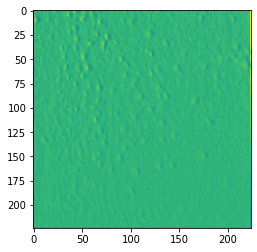

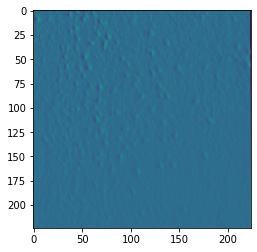

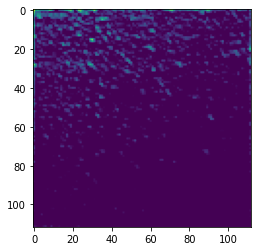

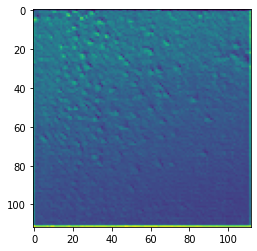

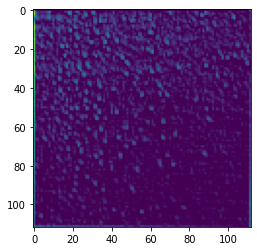

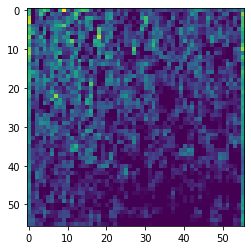

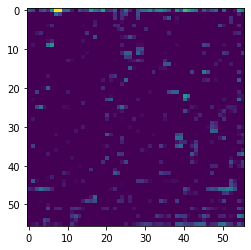

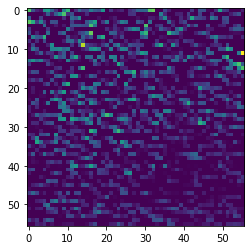

In [112]:
import random


chosen_image = train_data[10][0]
chosen_image = torch.reshape(chosen_image, (1,3, 224, 224))

filters = model.features._modules.items()
list_filters = list(filters)

layer1_image_tens = list_filters[0][1](chosen_image) #1 64 224 224
layer1_image = torch.reshape(layer1_image_tens, (64,224,224))
layer1_image = layer1_image.detach().numpy()

random_channel1 = random.randint(1,63)
random_channel2 = random.randint(1,63)
random_channel3 = random.randint(1,63)


layer1_image1 = layer1_image[random_channel1]
layer1_image2 = layer1_image[random_channel2]
layer1_image3 = layer1_image[random_channel3]
plt.figure()
plt.imshow(layer1_image1)
plt.figure()
plt.imshow(layer1_image2)
plt.figure()
plt.imshow(layer1_image3)

#getting from layer 1-5
layer2_image_tens = list_filters[1][1](layer1_image_tens)
layer3_image_tens = list_filters[2][1](layer2_image_tens)
layer4_image_tens = list_filters[3][1](layer3_image_tens)

## layer 5
layer5_image_tens = list_filters[4][1](layer4_image_tens)

layer5_image = torch.reshape(layer5_image_tens, (64,112,112))
layer5_image = layer5_image.detach().numpy()

random_channel1 = random.randint(1,63)
random_channel2 = random.randint(1,63)
random_channel3 = random.randint(1,63)

layer5_image1 = layer5_image[random_channel1]
layer5_image2 = layer5_image[random_channel2]
layer5_image3 = layer5_image[random_channel3]
plt.figure()
plt.imshow(layer5_image1)
plt.figure()
plt.imshow(layer5_image2)
plt.figure()
plt.imshow(layer5_image3)
# go from layer 5-10

layer6_image_tens = list_filters[5][1](layer5_image_tens)
layer7_image_tens = list_filters[6][1](layer6_image_tens)
layer8_image_tens = list_filters[7][1](layer7_image_tens)
layer9_image_tens = list_filters[8][1](layer8_image_tens)

#layer10
layer10_image = list_filters[9][1](layer9_image_tens)

layer10_image = torch.reshape(layer10_image, (128,56,56))

layer10_image = layer10_image.detach().numpy()

random_channel1 = random.randint(1,127)
random_channel2 = random.randint(1,127)
random_channel3 = random.randint(1,127)

layer10_image1 = layer10_image[random_channel1]
layer10_image2 = layer10_image[random_channel2]
layer10_image3 = layer10_image[random_channel3]
plt.figure()
plt.imshow(layer10_image1)
plt.figure()
plt.imshow(layer10_image2)
plt.figure()
plt.imshow(layer10_image3)

What do you observe?

In [113]:
# the features, surface defects, are visible in the first layer, even moreso than in the original images.
# The fifth filter yields lower level data, amplifying small defects in the metal
#After the tenth filter, the data becomes less interpretable and more lendable to an encoding

### 1.3 (20 points) Train a Classifier with Transfer Learning

Define a VGG-based transfer learning classifier.

In [114]:
class VGG_mlp_fc1(nn.Module):
    def __init__(self, pretrain=True):
        super(VGG_mlp_fc1, self).__init__()
        self.features = vgg16(pretrained=pretrain).features # convolutional layers
        self.avgpool = vgg16(pretrained=pretrain).avgpool
        self.fc1 = vgg16(pretrained=pretrain).classifier[0] # first layer of classifier
        self.layers = []
        self.layers += [torch.nn.Linear(4096, 2048)]
        self.layers += [torch.nn.ReLU()]
        self.layers += [torch.nn.Linear(2048, 6)]
        self.layers = torch.nn.Sequential(*self.layers)

    def forward(self, x):
        """Extract first fully connected feature vector"""
        # Apply convolutions
        x = self.features(x)
        # Apply pooling
        x = self.avgpool(x)
        # Flatten and convert to vectors
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.layers(x)
        return x

device = 'cuda:0'
# define your model
MLP_model = VGG_mlp_fc1(pretrain=True).to(device)
optimizer = torch.optim.Adam(list(MLP_model.layers.parameters()), lr=1e-3)




# class MLP(torch.nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.layers = []
#     self.layers += [torch.nn.Linear(4096, 2048)]
#     self.layers += [torch.nn.ReLU()]
#     self.model = torch.nn.Sequential(*self.layers)
    
#   def forward(self, x):
#     x = self.model(x)
        
#     return x






Train your classifier.

In [115]:


def train(model, dataloader, optimizer, device, evaluation=False):

  if evaluation:
    model.eval()
    mode = "eval"
  else:
    model.train()
    mode = 'train'

  # epoch_loss = []
  # MLP_model.train() # Set model to training mode 
  
  # tqdm_data = tqdm(dataloader, position=0, leave=True, desc='{} (epoch #{})'.format(mode, epoch))
  batch_loss = []
  for batch in dataloader:
    X, y = batch
    X = X.to(device)
    y = y.to(device)
        
        # train your model on each batch here 
    y_pred = model(X)
    #y_pred = torch.transpose(y_pred, 1, 0)
    y = y.view(-1)
    loss = torch.nn.functional.cross_entropy(y_pred, y)
    batch_loss.append(loss.item())
    
    if not evaluation:    
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
  return np.array(batch_loss).mean()

print("epoch", "train loss")
train_losses = []

for epoch in range(5):
  epoch_loss = train(MLP_model, train_loader, optimizer,  device=device)
  train_losses.append(epoch_loss)
  print(epoch, epoch_loss)

print("test loss")
print(train(MLP_model, test_loader, optimizer,  device=device, evaluation = True))



epoch train loss
0 0.3825484081182652
1 0.03280485122734709
2 0.04182985287666481
3 0.2038867070546638
4 0.04052050547784141
test loss
0.0018540366785812364


Compute and plot a test confusion matrix.

In [116]:

Y = np.array([])
Y_pred = np.array([])

for batch in test_loader:
  X, y = batch
  X = X.to(device)
  y = y.to(device)
  y = y.detach().cpu().numpy()
  y = np.squeeze(y)
  Y = np.hstack((Y,y))
  
  y_pred = MLP_model(X)
  y_pred = y_pred.detach().cpu().numpy()
  y_pred = np.squeeze(y_pred)
  y_pred = np.argmax(y_pred, axis=1)
  Y_pred = np.hstack((Y_pred,y_pred))


[[52  0  0  0  0  0]
 [ 0 73  0  0  0  0]
 [ 0  0 70  0  0  0]
 [ 0  0  0 56  0  0]
 [ 0  0  0  0 57  0]
 [ 0  0  0  0  0 52]]


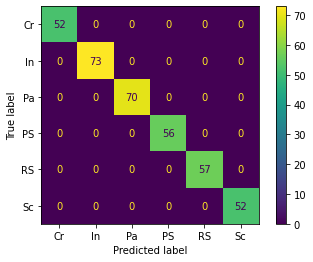

In [137]:
confusion = confusion_matrix(Y,Y_pred)
print(confusion)
ConfusionMatrixDisplay.from_predictions(Y, Y_pred,display_labels=['Cr','In','Pa','PS','RS','Sc'])
plt.show()

Why do you need to resize images to specific shapes and normalize pixel values to specific values for each color channel?

In [118]:
#CNN archetectures are made for a given input size to avoid rounding when pooling.
#Since one learning rate is used, normalizing pixel values allows for smaller oscilations while optimizing cost vs weights
#This must be done for each color chanel because each may need to be normalized differently
#to achieve similar distributions in each channel, since each channel sees the same gradients when learning.
#This is especially important for transfer learning since inputs would have more variability than those from one domain.

What are the benefits of transfer learning versus training the entire stack (CNN + MLP) again. What are the potential limitations of this approach? 

In [119]:
#Larger datasets let models learn richer feature vectors than those trained from smaller datasets.
#Even though the objective of the CNN was different than that of our MLP, it captured many intrensic properties of
#classification due to it being trained to classify an enormous number of labels.
#There is a trade-off since the utility of the feature vectors learned depends on the objective.
#This would be troublesome if the task at hand was too specific to be learned from the more general CNN that saw more examples.
#So training the entire stack could lend to more useful feature vectors specified to the task at hand,
#but there was likely not enough data for this. 

### 1.4 (15 points) Obtain Saliency Maps

Compute the saliency map for two images of each class.


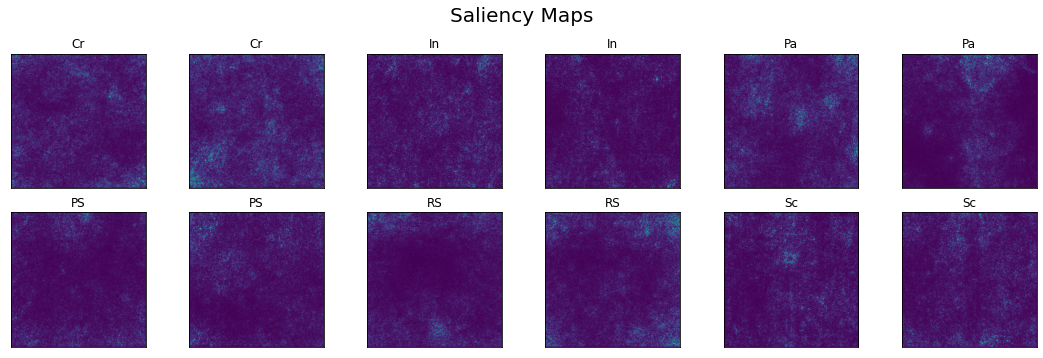

In [120]:
#select two images with each defect class:
label_dict = {
'Cr': 0, 
'In': 1, 
'Pa': 2,
'PS': 3, 
'RS': 4,
'Sc': 5
}

Cr_images = []
In_images = []
Pa_images = []
PS_images = []
RS_images = []
Sc_images = []

for i in range(0,test_data.__len__()):
  label = test_data[i][1]
  label = label.detach().cpu().numpy()[0]
  if label == 0:
    if len(Cr_images) > 2:
      continue
    Cr_images.append(test_data[i][0])
  if label == 1:
    if len(In_images) > 2:
      continue
    In_images.append(test_data[i][0])
  if label == 2:
    if len(Pa_images) > 2:
      continue
    Pa_images.append(test_data[i][0])
  if label == 3:
    if len(PS_images) > 2:
      continue
    PS_images.append(test_data[i][0])
  if label == 4:
    if len(RS_images) > 2:
      continue
    RS_images.append(test_data[i][0])
  if label == 5:
    if len(Sc_images) > 2:
      continue
    Sc_images.append(test_data[i][0])


# image = Sc_images[0]
# image = torch.reshape(image, (1,3, 224, 224))
# image = image.to(device)
# image = image.requires_grad_()

# ytst = MLP_model(image).max()
# ytst_grad = ytst.backward()
# x_grad = image.grad.data
# x_grad = torch.reshape(x_grad, (3, 224, 224))
# x_grad = torch.abs(x_grad)
# x_grad = torch.mean(x_grad, 0)
# x_grad_np = x_grad.detach().cpu().numpy()
# fig, (ax1, ax2) = plt.subplots(1,2)
# ax1.imshow(x_grad_np)
# ax2.imshow(x_grad_np)
# plt.show()


fig, ([ax1, ax2, ax3, ax4, ax5, ax6], [ax7, ax8, ax9, ax10, ax11, ax12]) = plt.subplots(2,6)
fig.suptitle('Saliency Maps', fontsize=20)
fig.set_figheight(5)
fig.set_figwidth(15)

ax1.set_title('Cr')
image = Cr_images[0]
image = torch.reshape(image, (1,3, 224, 224))
image = image.to(device)
image = image.requires_grad_()
ytst = MLP_model(image).max()
ytst_grad = ytst.backward()
x_grad = image.grad.data
x_grad = torch.reshape(x_grad, (3, 224, 224))
x_grad = torch.abs(x_grad)
x_grad = torch.mean(x_grad, 0)
x_grad_np = x_grad.detach().cpu().numpy()
ax1.imshow(x_grad_np)
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)

ax2.set_title('Cr')
image = Cr_images[1]
image = torch.reshape(image, (1,3, 224, 224))
image = image.to(device)
image = image.requires_grad_()
ytst = MLP_model(image).max()
ytst_grad = ytst.backward()
x_grad = image.grad.data
x_grad = torch.reshape(x_grad, (3, 224, 224))
x_grad = torch.abs(x_grad)
x_grad = torch.mean(x_grad, 0)
x_grad_np = x_grad.detach().cpu().numpy()
ax2.imshow(x_grad_np)
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)

ax3.set_title('In')
image = In_images[0]
image = torch.reshape(image, (1,3, 224, 224))
image = image.to(device)
image = image.requires_grad_()
ytst = MLP_model(image).max()
ytst_grad = ytst.backward()
x_grad = image.grad.data
x_grad = torch.reshape(x_grad, (3, 224, 224))
x_grad = torch.abs(x_grad)
x_grad = torch.mean(x_grad, 0)
x_grad_np = x_grad.detach().cpu().numpy()
ax3.imshow(x_grad_np)
ax3.xaxis.set_visible(False)
ax3.yaxis.set_visible(False)

ax4.set_title('In')
image = In_images[1]
image = torch.reshape(image, (1,3, 224, 224))
image = image.to(device)
image = image.requires_grad_()
ytst = MLP_model(image).max()
ytst_grad = ytst.backward()
x_grad = image.grad.data
x_grad = torch.reshape(x_grad, (3, 224, 224))
x_grad = torch.abs(x_grad)
x_grad = torch.mean(x_grad, 0)
x_grad_np = x_grad.detach().cpu().numpy()
ax4.imshow(x_grad_np)
ax4.xaxis.set_visible(False)
ax4.yaxis.set_visible(False)

ax5.set_title('Pa')
image = Pa_images[0]
image = torch.reshape(image, (1,3, 224, 224))
image = image.to(device)
image = image.requires_grad_()
ytst = MLP_model(image).max()
ytst_grad = ytst.backward()
x_grad = image.grad.data
x_grad = torch.reshape(x_grad, (3, 224, 224))
x_grad = torch.abs(x_grad)
x_grad = torch.mean(x_grad, 0)
x_grad_np = x_grad.detach().cpu().numpy()
ax5.imshow(x_grad_np)
ax5.xaxis.set_visible(False)
ax5.yaxis.set_visible(False)

ax6.set_title('Pa')
image = Pa_images[1]
image = torch.reshape(image, (1,3, 224, 224))
image = image.to(device)
image = image.requires_grad_()
ytst = MLP_model(image).max()
ytst_grad = ytst.backward()
x_grad = image.grad.data
x_grad = torch.reshape(x_grad, (3, 224, 224))
x_grad = torch.abs(x_grad)
x_grad = torch.mean(x_grad, 0)
x_grad_np = x_grad.detach().cpu().numpy()
ax6.imshow(x_grad_np)
ax6.xaxis.set_visible(False)
ax6.yaxis.set_visible(False)

ax7.set_title('PS')
image = PS_images[0]
image = torch.reshape(image, (1,3, 224, 224))
image = image.to(device)
image = image.requires_grad_()
ytst = MLP_model(image).max()
ytst_grad = ytst.backward()
x_grad = image.grad.data
x_grad = torch.reshape(x_grad, (3, 224, 224))
x_grad = torch.abs(x_grad)
x_grad = torch.mean(x_grad, 0)
x_grad_np = x_grad.detach().cpu().numpy()
ax7.imshow(x_grad_np)
ax7.xaxis.set_visible(False)
ax7.yaxis.set_visible(False)

ax8.set_title('PS')
image = PS_images[1]
image = torch.reshape(image, (1,3, 224, 224))
image = image.to(device)
image = image.requires_grad_()
ytst = MLP_model(image).max()
ytst_grad = ytst.backward()
x_grad = image.grad.data
x_grad = torch.reshape(x_grad, (3, 224, 224))
x_grad = torch.abs(x_grad)
x_grad = torch.mean(x_grad, 0)
x_grad_np = x_grad.detach().cpu().numpy()
ax8.imshow(x_grad_np)
ax8.xaxis.set_visible(False)
ax8.yaxis.set_visible(False)

ax9.set_title('RS')
image = RS_images[0]
image = torch.reshape(image, (1,3, 224, 224))
image = image.to(device)
image = image.requires_grad_()
ytst = MLP_model(image).max()
ytst_grad = ytst.backward()
x_grad = image.grad.data
x_grad = torch.reshape(x_grad, (3, 224, 224))
x_grad = torch.abs(x_grad)
x_grad = torch.mean(x_grad, 0)
x_grad_np = x_grad.detach().cpu().numpy()
ax9.imshow(x_grad_np)
ax9.xaxis.set_visible(False)
ax9.yaxis.set_visible(False)

ax10.set_title('RS')
image = RS_images[1]
image = torch.reshape(image, (1,3, 224, 224))
image = image.to(device)
image = image.requires_grad_()
ytst = MLP_model(image).max()
ytst_grad = ytst.backward()
x_grad = image.grad.data
x_grad = torch.reshape(x_grad, (3, 224, 224))
x_grad = torch.abs(x_grad)
x_grad = torch.mean(x_grad, 0)
x_grad_np = x_grad.detach().cpu().numpy()
ax10.imshow(x_grad_np)
ax10.xaxis.set_visible(False)
ax10.yaxis.set_visible(False)

ax11.set_title('Sc')
image = Sc_images[0]
image = torch.reshape(image, (1,3, 224, 224))
image = image.to(device)
image = image.requires_grad_()
ytst = MLP_model(image).max()
ytst_grad = ytst.backward()
x_grad = image.grad.data
x_grad = torch.reshape(x_grad, (3, 224, 224))
x_grad = torch.abs(x_grad)
x_grad = torch.mean(x_grad, 0)
x_grad_np = x_grad.detach().cpu().numpy()
ax11.imshow(x_grad_np)
ax11.xaxis.set_visible(False)
ax11.yaxis.set_visible(False)

ax12.set_title('Sc')
image = Sc_images[1]
image = torch.reshape(image, (1,3, 224, 224))
image = image.to(device)
image = image.requires_grad_()
ytst = MLP_model(image).max()
ytst_grad = ytst.backward()
x_grad = image.grad.data
x_grad = torch.reshape(x_grad, (3, 224, 224))
x_grad = torch.abs(x_grad)
x_grad = torch.mean(x_grad, 0)
x_grad_np = x_grad.detach().cpu().numpy()
ax12.imshow(x_grad_np)
ax12.xaxis.set_visible(False)
ax12.yaxis.set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

Comment on any pattern you observe in the saliency maps.

In [121]:
#Similar patterns exist for each label, but they are not as similar as I would have thought. This is probably due to
#the fact that the label-indicating features do not always exist in the same spots on the images.
#The salient parts of the images are also not limited to the defects, perhaps because the metal around them, which would be less
#classifiable by eye alone, have meaningful information.

# Part 2: Image Segmentation

### 2.1 (15 points) Build Datasets and DataLoaders

Download and unzip data.

In [122]:
!wget -O part2data.zip https://raw.githubusercontent.com/vikram-sundar/ML4MolEng_Spring2022/master/psets/ps5/data/part2_data.zip
! rm -r segmentation_data
! mkdir segmentation_data/
! unzip part2data.zip -d segmentation_data

Streaming output truncated to the last 5000 lines.
  inflating: segmentation_data/part2_segdata/1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5/masks/8764f0cef29977b4d47fb037851a71af14987901a6aa6737bec57dc050750fd7.png  
  inflating: segmentation_data/part2_segdata/1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5/masks/c6a7a0c3c89a1e2ca5c068a61e6e9f84390233dbc587792503f348296ac6b78f.png  
  inflating: segmentation_data/part2_segdata/1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5/masks/3382020ee0ed65d8d303751947fd261e3c64d823b27d756a9871b5dde2129462.png  
  inflating: segmentation_data/part2_segdata/1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5/masks/9fd1c120f489218285c8fae05dc8ee20e5518443d8428bbca0c50343d4695a15.png  
  inflating: segmentation_data/part2_segdata/1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5/masks/97027951540138eb9e8b8abaa7ea1633419ef1bfe75418e7fb97e6a83d272e19.png  
  inflating: s

Parse data from image filepaths.

In [151]:
paths = glob.glob("segmentation_data/part2_segdata/*")

def parse_data(path):

    # define data folders
    x_path = os.path.join(path, "images/")
    y_path = os.path.join(path, "masks/")

    # get all data paths 
    x_file = glob.glob(os.path.join(x_path, "*.png"))[0]
    y_files = glob.glob(os.path.join(y_path, "*.png"))

    # parse in data
    x = imageio.imread(x_file)
    
    masks = np.array([imageio.imread(y) for y in y_files])
    y = np.zeros_like(masks[0])
    for y_raw in masks:
        y = np.maximum(y, y_raw)

    # normalize
    x = x / 255.0
    y = y / 255.0

    return x, y

Load one image.

In [152]:
x, y = parse_data(paths[0])
print(x.shape, y.shape)

(256, 256, 4) (256, 256)


Your ImageDataset class.

In [233]:
class ImageDataset(Dataset):
    def __init__(self, paths):
        
        '''
        Image dataset object that loads and transforms images. 
        
        '''
        self.paths = paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        #########your implementation here######### 
        
        images = parse_data(paths[idx])[0] #256 256 4
        masks = parse_data(paths[idx])[1] 

        #transfer to channel-first tensors
        images = transforms.ToTensor()(images) #4 256 256
        masks = transforms.ToTensor()(masks) #1 256 256

        #apply random rotation
        angle = random.randint(-60, 60)
        images = transforms.functional.rotate(images,angle)
        masks = transforms.functional.rotate(masks,angle)
        sample = [images, masks]
        return sample

Split your data and load your DataLoaders.

In [234]:
tr_andv_files, test_files = train_test_split(paths, test_size = 0.2)
train_files, val_files = train_test_split(tr_andv_files,test_size=0.1/0.8)

train_data = ImageDataset(train_files)
val_data = ImageDataset(val_files)
test_data = ImageDataset(test_files)

#print(ImageDataset(train_files).__getitem__(10))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=True)

Is it necessary to apply random translation to your image?  Briefly justify your answer.

In [224]:
#This is not necessary because CNNs are inherantly translation-invariant.
#Max pooling summarizes the features captured by the filters and discards their positions,
#conferring translational invariance.

a = torch.tensor([])
b = torch.tensor([2,3])
c = torch.cat((a,b))
print(c)



tensor([2., 3.])


### 2.2 (20 points) Train a U-Net Model that Performs Image Segmentation

Implement Dice loss.

In [225]:
def dice_loss(pred, target):
    """Calculate Dice loss.

    Parameters
    ----------
        pred:
            predictions from the model
        target:
            ground truth label
    """
    if pred.shape[0] == 4:
      loss1 = 1- ((2*torch.sum(torch.mul(pred[0],target[0])))+1)/(torch.sum(pred[0])+torch.sum(target[0])+1)
      loss2 = 1- ((2*torch.sum(torch.mul(pred[1],target[1])))+1)/(torch.sum(pred[1])+torch.sum(target[1])+1)
      loss3 = 1- ((2*torch.sum(torch.mul(pred[2],target[2])))+1)/(torch.sum(pred[2])+torch.sum(target[2])+1)
      loss4 = 1- ((2*torch.sum(torch.mul(pred[3],target[3])))+1)/(torch.sum(pred[3])+torch.sum(target[3])+1)
      losses = torch.stack((loss1,loss2,loss3,loss4),dim=0)

    if pred.shape[0] == 3:
      loss1 = 1- ((2*torch.sum(torch.mul(pred[0],target[0])))+1)/(torch.sum(pred[0])+torch.sum(target[0])+1)
      loss2 = 1- ((2*torch.sum(torch.mul(pred[1],target[1])))+1)/(torch.sum(pred[1])+torch.sum(target[1])+1)
      loss3 = 1- ((2*torch.sum(torch.mul(pred[2],target[2])))+1)/(torch.sum(pred[2])+torch.sum(target[2])+1)
      losses = torch.stack((loss1,loss2,loss3),dim=0)

    if pred.shape[0] == 2:
      loss1 = 1- ((2*torch.sum(torch.mul(pred[0],target[0])))+1)/(torch.sum(pred[0])+torch.sum(target[0])+1)
      loss2 = 1- ((2*torch.sum(torch.mul(pred[1],target[1])))+1)/(torch.sum(pred[1])+torch.sum(target[1])+1)
      losses = torch.stack((loss1,loss2,loss3),dim=0)

    if pred.shape[0] == 1:
      loss1 = 1- ((2*torch.sum(torch.mul(pred[0],target[0])))+1)/(torch.sum(pred[0])+torch.sum(target[0])+1)
      losses = loss1


    return torch.mean(losses)


The U-Net Model.

In [226]:
class DownSampling(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, name=None):
        super(DownSampling, self).__init__()

        self.conv = ConvBlock(in_channels, out_channels, kernel_size)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):

        conv_out = self.conv(x)
        output = self.max_pool(conv_out)

        return output, conv_out


class UpSampling(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, name=None):
        super(UpSampling, self).__init__()

        self.conv = ConvBlock(in_channels, out_channels, kernel_size)
        self.conv_t = nn.ConvTranspose2d(out_channels, out_channels, kernel_size, \
                                         padding=1, stride=2, output_padding=1)


    def forward(self, x, skip):

        conv_out = self.conv(x)
        output = self.conv_t(conv_out)

        output += skip

        return output


class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, padding=1, stride=1, name=None):
        super(ConvBlock, self).__init__()

        block = []
        # first conv layer
        block.append(nn.Conv2d(in_channels, out_channels, kernel_size, \
                               padding=padding, stride=stride))
        block.append(nn.ReLU())
        block.append(nn.BatchNorm2d(out_channels))

        # second conv layer
        block.append(nn.Conv2d(out_channels, out_channels, kernel_size, \
                               padding=padding, stride=stride))
        block.append(nn.ReLU())
        block.append(nn.BatchNorm2d(out_channels))

        # make sequential
        self.conv_block = nn.Sequential(*block)


    def forward(self, x):

        output = self.conv_block(x)

        return output
    
    
class UNet(nn.Module):

    def __init__(self, num_kernel=8, kernel_size=3, dim=4, target_dim=1):
        """UNet

        Inputs:
            num_kernel: int
                number of kernels to use for the first layer
            kernel_size: int
                size of the kernel for the first layer
            dims: int
                number of color channels for input images 
            target_dim: int 
                number of channels for the output mask
        """

        super(UNet, self).__init__()

        self.num_kernel = num_kernel
        self.kernel_size = kernel_size
        self.dim = dim
        self.target_dim = 1

        # encode
        self.encode_1 = DownSampling(self.dim, num_kernel, kernel_size)
        self.encode_2 = DownSampling(num_kernel, num_kernel*2, kernel_size)
        self.encode_3 = DownSampling(num_kernel*2, num_kernel*4, kernel_size)
        self.encode_4 = DownSampling(num_kernel*4, num_kernel*8, kernel_size)

        # bridge
        self.bridge = nn.Conv2d(num_kernel*8, num_kernel*16, kernel_size, padding=1, stride=1)

        # decode
        self.decode_4 = UpSampling(num_kernel*16, num_kernel*8, kernel_size)
        self.decode_3 = UpSampling(num_kernel*8, num_kernel*4, kernel_size)
        self.decode_2 = UpSampling(num_kernel*4, num_kernel*2, kernel_size)
        self.decode_1 = UpSampling(num_kernel*2, num_kernel, kernel_size)

        self.segment = nn.Conv2d(num_kernel, self.target_dim, 1, padding=0, stride=1)
        self.activate = nn.Sigmoid()


    def forward(self, x):

        x, skip_1 = self.encode_1(x)
        x, skip_2 = self.encode_2(x)
        x, skip_3 = self.encode_3(x)
        x, skip_4 = self.encode_4(x)

        x = self.bridge(x)

        x = self.decode_4(x, skip_4)
        x = self.decode_3(x, skip_3)
        x = self.decode_2(x, skip_2)
        x = self.decode_1(x, skip_1)

        x = self.segment(x)

        pred = self.activate(x)

        return pred


    def args_dict(self):
        """model arguments to be saved
        """

        model_args = {'dim': self.dim,
                      'target_dim': self.target_dim,
                      'num_kernel' : self.num_kernel,
                      'kernel_size' : self.kernel_size}

        return model_args


Example model usage.

In [227]:
model = UNet()
y = model(torch.randn(1, 4, 256, 256))

print(y.shape)

torch.Size([1, 1, 256, 256])


A function to plot a segmentation map.

In [228]:
def plot_seg(image, pred_seg, true_seg, mask_cutoff=0.1):

    """ Visualize segmentation results.
    Inputs:
        image: orginal image, shape: 256 x 256 x 4
        pred_seg: predicted mask, shape: 256 x 256 x 1 or 256 x 256 
        true_seg: true mask, shape: 256 x 256 x 1 or 256 x 256
        mask_cutoff: if the mask values is larger than mask_cutoff, the mask will appear on the image
    """
    
    fig, ax = plt.subplots(1, 3, sharex='col', sharey='row')
    fig.set_size_inches((15,15))
    
    pred_seg = pred_seg.squeeze()
    true_seg = pred_seg.squeeze()

    ax[0].set_title("Original Image")
    ax[1].set_title("Prediction")
    ax[2].set_title("Ground Truth")

    pred_mask = np.zeros((256, 256))
    pred_mask[pred_seg > mask_cutoff] = 1
    y_mask = np.zeros((256, 256))
    y_mask[true_seg > mask_cutoff] = 1

    ax[0].imshow(image)
    ax[1].imshow(color.label2rgb(pred_mask,image,colors=[(255,0,0)],alpha=0.0025, bg_label=0, bg_color=None))
    ax[2].imshow(color.label2rgb(y_mask,image,colors=[(255,0,0)],alpha=0.0025, bg_label=0, bg_color=None))

    plt.show()

Train your model.

In [237]:
model = UNet()
optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-3)

def train(model, dataloader, optimizer, device, evaluation=False):

  if evaluation:
    model.eval()
    mode = "eval"
  else:
    model.train()
    mode = 'train'

  # epoch_loss = []
  # MLP_model.train() # Set model to training mode 
  
  batch_loss = []
  for batch in dataloader:

    X, y = batch
    X = X.to(torch.float32)
    y = y.to(torch.float32)
    X = X.to('cpu')
    y = y.to('cpu')
        
        # train your model on each batch here 
    y_pred = model(X)
    #y_pred = torch.transpose(y_pred, 1, 0)
    #y = y.view(-1)
    loss = dice_loss(y_pred, y)
    batch_loss.append(loss.item())
    
    if not evaluation:    
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
  return np.array(batch_loss).mean()

print("epoch", "train loss")
train_losses = []

for epoch in range(20):
  epoch_loss = train(model, train_loader, optimizer,  device=device)
  train_losses.append(epoch_loss)
  print(epoch, epoch_loss)

print("test loss")
print(train(model, train_loader, optimizer,  device=device, evaluation = True))

epoch train loss
0 0.7460663783348213
1 0.5847656120688228
2 0.39641512778855986
3 0.23106796736434354
4 0.16003714905957045
5 0.16913640398090168
6 0.15976408401788292
7 0.13375978399131258
8 0.12689229542926206
9 0.12296646151502254
10 0.11719622955483905
11 0.11428540237879349
12 0.10994306358240419
13 0.1112857498859955
14 0.10699655393422661
15 0.10125794577396523
16 0.10131730947454097
17 0.11222891787351189
18 0.09843350643828763
19 0.09982759998006335
test loss
0.0915550872430963


Show segmentation results for 3 images from the test dataset.

/usr/local/lib/python3.7/dist-packages/skimage/color/colorlabel.py:168: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  image = img_as_float(rgb2gray(image))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


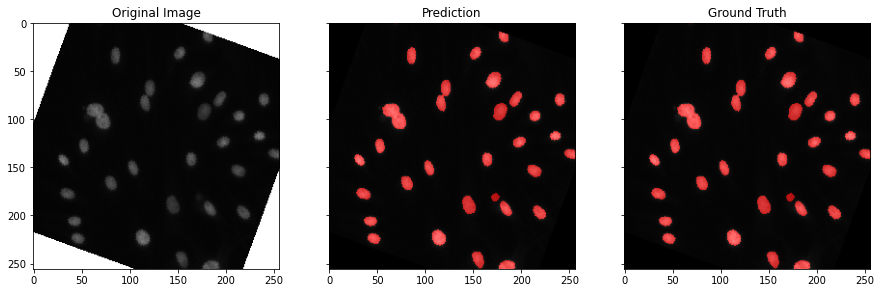

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


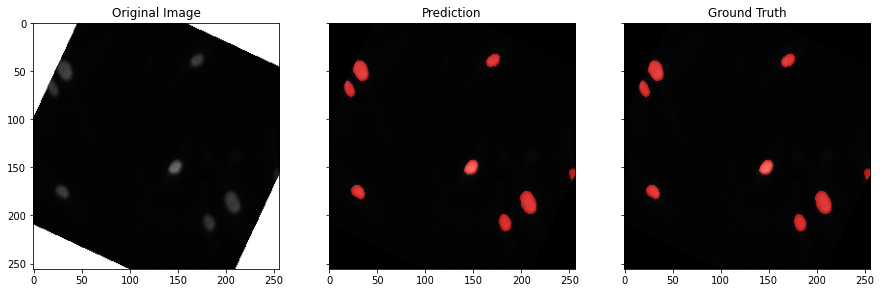

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


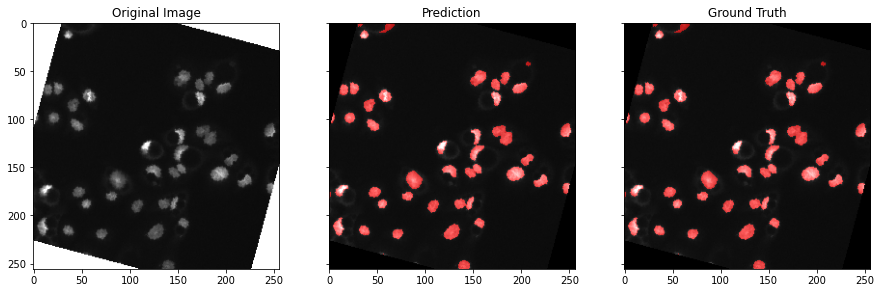

In [256]:
model.eval()

chosen_image1 = train_data[1][0]
chosen_image2 = train_data[2][0]
chosen_image3 = train_data[3][0]

chosen1 = torch.reshape(chosen_image1, (1,4, 256, 256))
chosen1 = chosen1.to(torch.float32)
chosen2 = torch.reshape(chosen_image2, (1,4, 256, 256))
chosen2 = chosen2.to(torch.float32)
chosen3 = torch.reshape(chosen_image3, (1,4, 256, 256))
chosen3 = chosen3.to(torch.float32)


pred1 = model(chosen1)
pred2 = model(chosen2)
pred3 = model(chosen3)


chosen_image1 = chosen_image1.detach().cpu().numpy()
chosen_image2 = chosen_image2.detach().cpu().numpy()
chosen_image3 = chosen_image3.detach().cpu().numpy()

chosen_image1 = chosen_image1.transpose(1,2,0)
chosen_image2 = chosen_image2.transpose(1,2,0)
chosen_image3 = chosen_image3.transpose(1,2,0)

true1 = train_data[1][1].detach().cpu().numpy()
true2 = train_data[2][1].detach().cpu().numpy()
true3 = train_data[3][1].detach().cpu().numpy()
true1 = true1.transpose(1,2,0)
true2 = true2.transpose(1,2,0)
true3 = true3.transpose(1,2,0)

plot_seg(chosen_image1,pred1,true1)
plot_seg(chosen_image2,pred2,true2)
plot_seg(chosen_image3,pred3,true3)